In [1]:
from search_qa import run_search, make_client, search_dense
import json
from tqdm.auto import tqdm
import matplotlib.pyplot as plt



from dotenv import load_dotenv
from dotenv import dotenv_values

from openai import OpenAI

from fastembed import TextEmbedding
import numpy as np



db_client = make_client()

config = dotenv_values(".env")
api_key = config.get("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)


ground_truth = "Data/ground_truth.json"
with open(ground_truth, "r", encoding="utf-8") as f:
        ground_truth=json.load(f)
        
        
data_with_id = "Data/data_with_id.json"  
with open(data_with_id, "r", encoding="utf-8") as f:
        data_with_id=json.load(f)

        
doc_idx = {d['id']: d for d in data_with_id}
        

In [2]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

    QUESTION: {question}

    CONTEXT: 
    {context}
    """.strip()

    context = ""
    
    for doc in search_results:
        context = context + f"question: {doc.payload['question']}\n answer: {doc.payload['answer']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [3]:

def llm(prompt, model='gpt-4o'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [4]:
def rag(query,method, model='gpt-4o-mini',limit=5) -> str:
    search_results = run_search(method, query, client=db_client,limit=limit)
    prompt = build_prompt(query, search_results)
    answer = llm(prompt, model=model)
    return answer

In [6]:
answers={}

In [7]:
i=0
for id,questions  in tqdm(ground_truth.items()):
    
    questions_list=json.loads(questions)
    answer_origin=doc_idx[id]['answer']
    
    for q in questions_list:
        if i not in answers:
            answer_llm=rag(q,'dense')

            answers[i] = {
            'answer_llm': answer_llm,
            'answer_orig': answer_origin,
            'document': id,
            'question': q
            }
        i=i+1

  0%|          | 0/806 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
output_file = "Data/RAG_RESULTS.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(answers, f, ensure_ascii=False, indent=2)

In [8]:
RAG_RESULTS=answers


In [9]:
model = TextEmbedding(model_name="BAAI/bge-small-en-v1.5")


In [10]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    embeddings = list(model.embed([answer_orig, answer_llm]))
    emb1, emb2 = embeddings[0], embeddings[1]

    similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
    
    return similarity

In [39]:
similarity=[]
for record in tqdm(RAG_RESULTS):
    sim = compute_similarity(RAG_RESULTS[record])
    similarity.append(sim)
    
    

  0%|          | 0/4030 [00:00<?, ?it/s]

In [53]:
#Basic descriptive statistics

print("Count:", len(similarity))
print("Mean similarity:", np.mean(similarity))
print("Median similarity:", np.median(similarity))
print("Min similarity:", np.min(similarity))
print("Max similarity:", np.max(similarity))
print("Standard deviation:", np.std(similarity))

Count: 4030
Mean similarity: 0.8165864
Median similarity: 0.8480261
Min similarity: 0.35342222
Max similarity: 1.0000001
Standard deviation: 0.13033418


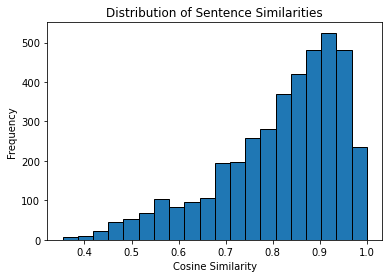

In [54]:
#Visualize the distribution
plt.hist(similarity, bins=20, edgecolor='black')
plt.title("Distribution of Sentence Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

